# **Generic** 

In [913]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

**Crop and Display Functions**

In [914]:
def crop_barcode3(img):
    # Find contours in the binary image
    contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour corresponds to the barcode
    largest_contour = max(contours, key=cv.contourArea)
    largest_contour_area = cv.contourArea(largest_contour)

    # Initialize variables to store the leftmost and rightmost contours
    leftmost_contour = None
    rightmost_contour = None
    x_min = float('inf')
    x_max = float('-inf')

    # Find the leftmost and rightmost contours
    for contour in contours:
        contour_area = cv.contourArea(contour)
        if contour_area >= 0.05 * largest_contour_area:  # Check if the contour area is significant
            x, _, w, _ = cv.boundingRect(contour)
            if x < x_min:
                x_min = x
                leftmost_contour = contour
            if x > x_max:  # Use x to get the far-right edge of the contour
                x_max = x
                rightmost_contour = contour

    x_min, _, _, _ = cv.boundingRect(leftmost_contour)
    x_max, _, w, _ = cv.boundingRect(rightmost_contour)

    # Get the vertical limits from the largest contour
    _, y, _, h = cv.boundingRect(largest_contour)

    # Crop the image so that only the barcode is visible
    cropped_img = img[y:y + h, x_min:x_max+w]

    # Draw all contours in red
    contour_img = cv.cvtColor(cv.bitwise_not(img), cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
    cv.drawContours(contour_img, contours, -1, (255, 0, 0), 4)  # Draw all contours in red

    return cropped_img, contour_img

def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    # Draw border around the image
    plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[0], fill=None, edgecolor='red', linewidth=1))
    plt.axis('off')
    plt.show()

**Read Image**

Select the number of the image you want to load:
1: 01 - lol easy.jpg
2: 02 - still easy.jpg
3: 03 - eda ya3am ew3a soba3ak mathazarsh.jpg
4: 04 - fen el nadara.jpg
5: 05 - meen taffa el nour!!!.jpg
6: 06 - meen fata7 el nour 333eenaaayy.jpg
7: 07 - mal7 w felfel.jpg
8: 08 - compresso espresso.jpg
9: 09 - e3del el soora ya3ammm.jpg
10: 10 - wen el kontraastttt.jpg
11: 11 - bayza 5ales di bsara7a.jpg
12: Screenshot 2024-12-12 231530.png


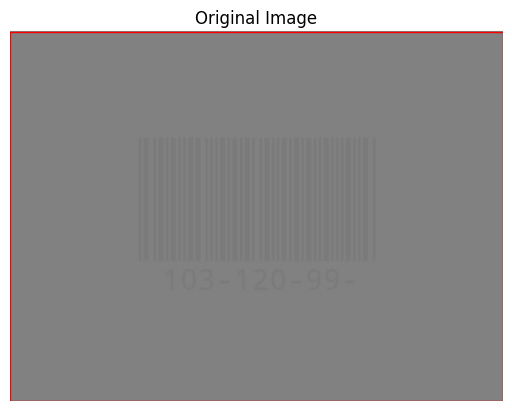

In [915]:
import cv2 as cv

# Prompt user to select the image number
print("Select the number of the image you want to load:")
print("1: 01 - lol easy.jpg")
print("2: 02 - still easy.jpg")
print("3: 03 - eda ya3am ew3a soba3ak mathazarsh.jpg")
print("4: 04 - fen el nadara.jpg")
print("5: 05 - meen taffa el nour!!!.jpg")
print("6: 06 - meen fata7 el nour 333eenaaayy.jpg")
print("7: 07 - mal7 w felfel.jpg")
print("8: 08 - compresso espresso.jpg")
print("9: 09 - e3del el soora ya3ammm.jpg")
print("10: 10 - wen el kontraastttt.jpg")
print("11: 11 - bayza 5ales di bsara7a.jpg")
print("12: Screenshot 2024-12-12 231530.png")

image_number = int(input("Enter the image number: "))

if image_number == 1:
    img = cv.imread('Samples/Test Cases/01 - lol easy.jpg')
elif image_number == 2:
    img = cv.imread('Samples/Test Cases/02 - still easy.jpg')
elif image_number == 3:
    img = cv.imread('Samples/Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg')
elif image_number == 4:
    img = cv.imread('Samples/Test Cases/04 - fen el nadara.jpg')
elif image_number == 5:
    img = cv.imread('Samples/Test Cases/05 - meen taffa el nour!!!.jpg')
elif image_number == 6:
    img = cv.imread('Samples/Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg')
elif image_number == 7:
    img = cv.imread('Samples/Test Cases/07 - mal7 w felfel.jpg')
elif image_number == 8:
    img = cv.imread('Samples/Test Cases/08 - compresso espresso.jpg')
elif image_number == 9:
    img = cv.imread('Samples/Test Cases/09 - e3del el soora ya3ammm.jpg')
elif image_number == 10:
    img = cv.imread('Samples/Test Cases/10 - wen el kontraastttt.jpg')
elif image_number == 11:
    img = cv.imread('Samples/Test Cases/11 - bayza 5ales di bsara7a.jpg')
elif image_number == 12:
    img = cv.imread('Samples/Screenshot 2024-12-12 231530.png')
else:
    print("Invalid image number. Please try again.")
    img = None

# Display the loaded image
if img is not None:
    display_image(cv.cvtColor(img, cv.COLOR_BGR2RGB), "Original Image")



**Isolate Barcode (Test Case 3)**

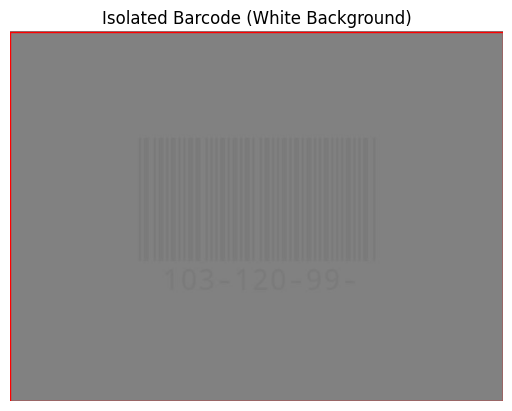

In [916]:
def isolate_barcode(image, threshold=10):
    
    # Convert image to float for better processing
    image = image.astype(np.float32)
    
    # Extract R, G, B channels
    B, G, R = cv.split(image)
    
    # Compute absolute differences between channels
    diff_rg = np.abs(R - G)
    diff_rb = np.abs(R - B)
    diff_gb = np.abs(G - B)
    
    # Create a mask where differences are below the threshold (grayscale condition)
    mask = (diff_rg < threshold) & (diff_rb < threshold) & (diff_gb < threshold)
    
    # Convert mask to binary (0 and 255)
    mask = mask.astype(np.uint8) * 255
    
    # Create a white canvas for the background
    white_canvas = np.ones_like(image, dtype=np.uint8) * 255  # White background
    
    # Apply mask to the original image to keep only grayscale pixels
    isolated_image = cv.bitwise_and(image, image, mask=mask)
    
    # Invert the mask to fill the background with white
    inverse_mask = cv.bitwise_not(mask)
    isolated_image += cv.bitwise_and(white_canvas, white_canvas, mask=inverse_mask)
    
    return isolated_image.astype(np.uint8)

# Isolate the barcode with white background
isolated_image = isolate_barcode(img, threshold=10)

display_image(cv.cvtColor(isolated_image, cv.COLOR_BGR2RGB), "Isolated Barcode (White Background)")


**Convert to Greyscale**

In [917]:
img = cv.cvtColor(isolated_image, cv.COLOR_BGR2GRAY)

**Apply Median Filter**

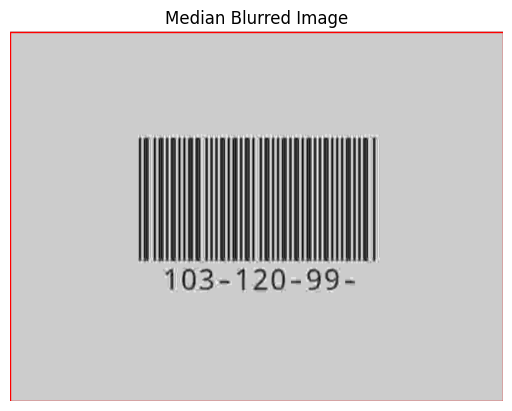

In [918]:
# Apply Median Blur
kernel = np.ones((3,1),np.float32)/3
median_blurred_img = cv.filter2D(img,-1,kernel)
display_image(median_blurred_img, 'Median Blurred Image')

**Thresholding**

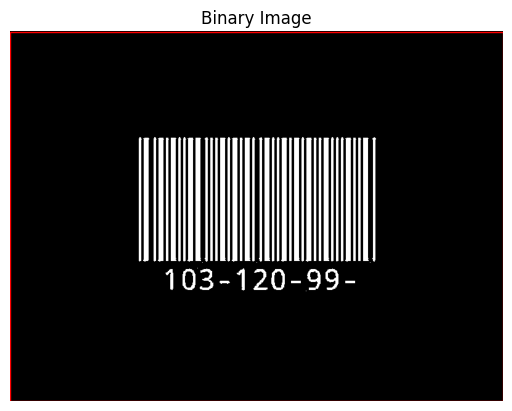

In [919]:
_, binary_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
display_image(binary_img, 'Binary Image')


**Fix Rotation**

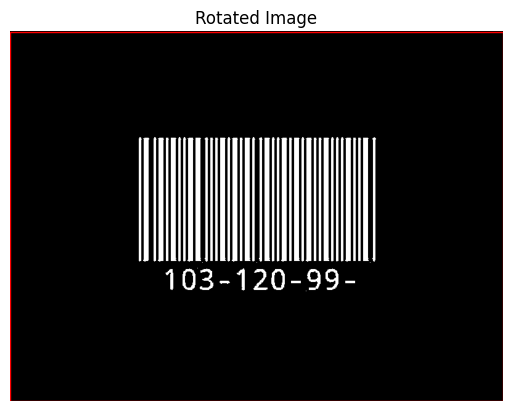

In [920]:
def detect_and_rotate(image):

    # Find contours
    contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    all_contours = []
    for contour in contours:
        if cv.contourArea(contour) > 100:  # Only consider larger contours that could be part of the barcode
            all_contours.append(contour)
    
    # Combine all contours to analyze the overall bounding rectangle
    combined_contour = np.vstack(all_contours)
    
    # Get the minimum area rectangle around the combined contour
    rect = cv.minAreaRect(combined_contour)
    angle = rect[2]
    
    # If the angle is not near zero, the barcode is rotated
    if abs(angle) > 1:  # Adjust this threshold if needed

        # Adjust the rotation angle
        if angle < -45:
            angle = 90 + angle
        elif angle > 45:
            angle = angle - 90

        # Compute the rotation matrix
        # Get the center of the bounding rectangle
        center = (int(rect[0][0]), int(rect[0][1]))

        # Get the rotation matrix
        rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)

        # Get the dimensions of the image
        rows, cols = image.shape[:2]

        # Rotate the image using warpAffine
        rotated_image = cv.warpAffine(image, rotation_matrix, (cols, rows), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

        return rotated_image

    else:
        return image  # No rotation needed

# Check and rotate the image if needed
rotated_img = detect_and_rotate(binary_img)

display_image(rotated_img, 'Rotated Image')

**Morph Open**

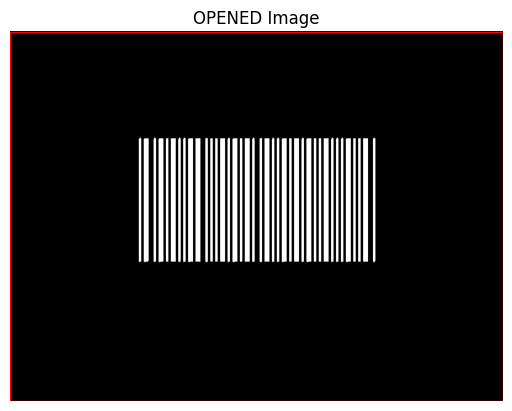

In [921]:
vertical_kernel = np.ones((60, 1), np.uint8)
opened_img = cv.morphologyEx(rotated_img, cv.MORPH_OPEN, vertical_kernel, iterations=1)
display_image(opened_img, 'OPENED Image')

**Crop, Close, Dilate**

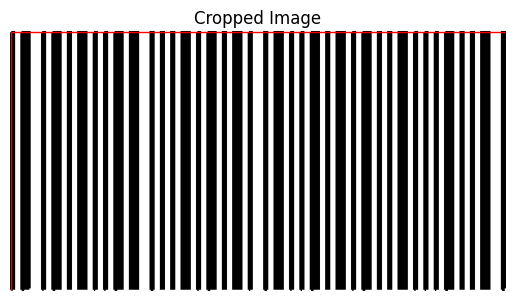

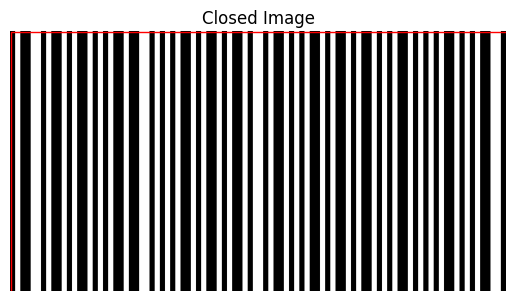

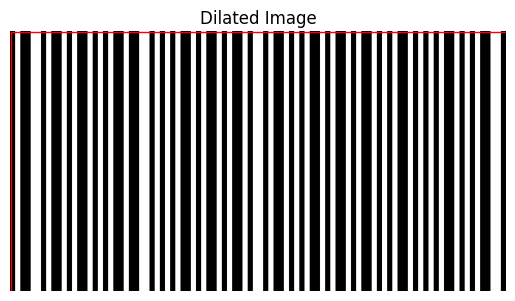

In [922]:
cropped_img, contour_img = crop_barcode3(opened_img)
display_image(cv.bitwise_not(cropped_img), 'Cropped Image')

# Close the cropped image
kernel = np.ones((100, 1), np.uint8)
closed_img = cv.morphologyEx(cropped_img, cv.MORPH_CLOSE, kernel, iterations=3)
display_image(cv.bitwise_not(closed_img), 'Closed Image')

# dilate the image
kernel = np.ones((1, 1), np.uint8)
dilated_img = cv.dilate(closed_img, kernel, iterations=2)
display_image(cv.bitwise_not(dilated_img), 'Dilated Image')

**Decode**

In [923]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Threshold the cropped image
mean = cv.bitwise_not(dilated_img).mean(axis=0)  # Column-wise mean
mean = np.where(mean <= 127, 1, 0)  # Black or White

print("Mean Array:", mean)  # Check the binary output

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    # Determine if the bar width is narrow or wide
    if 3 <= count <= 5:
        current_digit_widths += NARROW
    elif 7 <= count <= 9:
        current_digit_widths += WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)


if (image_number == 1):
    print("Expected Result: 1234567890-")
elif (image_number == 2):
    print("Expected Result: 104-116-116")
elif (image_number == 3):
    print("Expected Result: 112-115-58-")
elif (image_number == 4):
    print("Expected Result: -47-47-121-")
elif (image_number == 5):
    print("Expected Result: 111-117-116")
elif (image_number == 6):
    print("Expected Result: -117-46-98-")
elif (image_number == 7):
    print("Expected Result: 101-47-100-")
elif (image_number == 8):
    print("Expected Result: 113-119-52-")
elif (image_number == 9):
    print("Expected Result: 119-57-119-")
elif (image_number == 10):
    print("Expected Result: 103-120-99-")
elif (image_number == 11):
    print("Expected Result: 113-47-35-35")

Mean Array: [1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
Expected Result: 103-120-99-
